
# Food & Beverage Retail Analysis — Fixed Notebook



In [1]:

from __future__ import annotations

# Core
import os, json, math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, List

import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Stats / ML
from sklearn.preprocessing import PowerTransformer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# Display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

# Paths & config
@dataclass
class CFG:
    data_dir: str = "."
    fb_file: str = "Food-&-Beverage-stores.csv"
    covid_alcohol_file: str = "COVID-19 Alcohol.csv"
    covid_masks_file: str = "COVID-19 Face Masks.csv"
    covid_stayhome_file: str = "COVID-19 Stay at Home.csv"
    covid_start: str = "2020-03-01"
    covid_end: str = "2021-06-30"
    impact_start: str = "2020-03-01"
    impact_end: str = "2020-05-31"
    forecast_state: str = "WA"
    forecast_h: int = 6
    outlier_dates: Tuple[str, ...] = ("2020-03-01","2020-04-01","2020-05-01","2021-03-01")
    fig_dir: str = "figures"
    out_dir: str = "outputs"

CFG = CFG()

os.makedirs(CFG.fig_dir, exist_ok=True)
os.makedirs(CFG.out_dir, exist_ok=True)


## Helper Functions

In [2]:

STATE_TO_REGION = {
    # Northeast
    "CT":"Northeast","ME":"Northeast","MA":"Northeast","NH":"Northeast","RI":"Northeast","VT":"Northeast",
    "NJ":"Northeast","NY":"Northeast","PA":"Northeast",
    # Midwest
    "IL":"Midwest","IN":"Midwest","MI":"Midwest","OH":"Midwest","WI":"Midwest",
    "IA":"Midwest","KS":"Midwest","MN":"Midwest","MO":"Midwest","NE":"Midwest","ND":"Midwest","SD":"Midwest",
    # South
    "DE":"South","FL":"South","GA":"South","MD":"South","NC":"South","SC":"South","VA":"South","DC":"South","WV":"South",
    "AL":"South","KY":"South","MS":"South","TN":"South",
    "AR":"South","LA":"South","OK":"South","TX":"South",
    # West
    "AZ":"West","CO":"West","ID":"West","MT":"West","NV":"West","NM":"West","UT":"West","WY":"West",
    "AK":"West","CA":"West","HI":"West","OR":"West","WA":"West",
}

def date_index(df: pd.DataFrame, date_col: str = "observation_date") -> pd.DataFrame:
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    return df.set_index(date_col).sort_index()

def rename_msrs_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    new_cols = {}
    for col in out.columns:
        if col.startswith("MSRS") and len(col) >= 6:
            abbr = col[4:6]
            if abbr.isalpha() and abbr.isupper():
                new_cols[col] = abbr
    return out.rename(columns=new_cols)

def label_periods(df: pd.DataFrame) -> pd.DataFrame:
    covid_start = pd.to_datetime(CFG.covid_start)
    covid_end = pd.to_datetime(CFG.covid_end)
    def lab(ts):
        if ts < covid_start: return "pre_covid"
        if ts <= covid_end: return "covid"
        return "post_covid"
    out = df.copy()
    out["covid_period"] = [lab(ts) for ts in out.index]
    return out

def summarize_periods(df_lab: pd.DataFrame) -> pd.DataFrame:
    state_cols = [c for c in df_lab.columns if len(c)==2 and c.isupper()]
    tbl = (df_lab.groupby("covid_period")[state_cols].mean(numeric_only=True).mean(axis=1)
           .rename("avg_percent_change").reset_index())
    return tbl

def plot_period_bars(tbl: pd.DataFrame, savepath: str):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(tbl["covid_period"], tbl["avg_percent_change"])
    ax.set_title("Average % Change by Period (All States)")
    ax.set_xlabel("Period"); ax.set_ylabel("Average % Change")
    for i, v in enumerate(tbl["avg_percent_change"]):
        ax.text(i, v + 0.1, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
    plt.tight_layout(); plt.savefig(savepath, dpi=200); plt.show()

def compute_state_rankings_2020(df_lab: pd.DataFrame) -> pd.Series:
    state_cols = [c for c in df_lab.columns if len(c)==2 and c.isupper()]
    df2020 = df_lab.loc["2020-01-01":"2020-12-31", state_cols]
    return df2020.mean(numeric_only=True, axis=0).sort_values(ascending=False)

def plot_top_bottom_heatmap(rank: pd.Series, savepath: str, top_n: int = 5):
    sel = list(rank.head(top_n).index) + list(rank.tail(top_n).index)
    data = rank.loc[sel].to_frame("mean_2020").sort_values("mean_2020", ascending=False)
    # Simple heatmap via imshow:
    fig, ax = plt.subplots(figsize=(6, 0.5*len(sel)+1))
    im = ax.imshow(data.values, aspect="auto")
    ax.set_yticks(range(len(sel))); ax.set_yticklabels(data.index)
    ax.set_xticks([0]); ax.set_xticklabels(["mean_2020"])
    for i, v in enumerate(data["mean_2020"].values):
        ax.text(0, i, f"{v:.2f}", ha="center", va="center", color="white" if abs(v)>0 else "black")
    ax.set_title("Top/Bottom States in 2020 (Mean % Change)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.savefig(savepath, dpi=220); plt.show()

def safe_find_col(candidates: List[str], columns: List[str]) -> Optional[str]:
    lcols = [c.lower() for c in columns]
    for cand in candidates:
        cl = cand.lower()
        for i, c in enumerate(lcols):
            if cl in c:
                return columns[i]
    return None

def load_policy_features() -> pd.DataFrame:
    # Alcohol
    df_alc = pd.read_csv(os.path.join(CFG.data_dir, CFG.covid_alcohol_file))
    st = safe_find_col(["state"], df_alc.columns) or "State"
    alc = safe_find_col(["liquor store open","alcohol","open"], df_alc.columns)
    if alc is None:
        alc = [c for c in df_alc.columns if c != st][0]
    df_alc = df_alc[[st, alc]].copy(); df_alc.columns = ["state","alcohol_open"]

    # Masks
    df_mask = pd.read_csv(os.path.join(CFG.data_dir, CFG.covid_masks_file))
    st2 = safe_find_col(["state"], df_mask.columns) or "State"
    mask = safe_find_col(["fine","enforce","mask"], df_mask.columns)
    if mask is None:
        mask = [c for c in df_mask.columns if c != st2][0]
    df_mask = df_mask[[st2, mask]].copy(); df_mask.columns = ["state","mask_fines"]

    # Stay-home
    df_sh = pd.read_csv(os.path.join(CFG.data_dir, CFG.covid_stayhome_file))
    st3 = safe_find_col(["state"], df_sh.columns) or "State"
    s_col = safe_find_col(["start"], df_sh.columns)
    e_col = safe_find_col(["end"], df_sh.columns)
    if s_col is None or e_col is None:
        date_cols = [c for c in df_sh.columns if any(k in c.lower() for k in ["date","start","end"])]
        if len(date_cols) >= 2: s_col, e_col = date_cols[:2]
        else: raise ValueError("Could not detect stay-home start/end columns.")
    df_sh = df_sh[[st3, s_col, e_col]].copy()
    df_sh.columns = ["state","sh_start","sh_end"]
    df_sh["sh_start"] = pd.to_datetime(df_sh["sh_start"], errors="coerce")
    df_sh["sh_end"] = pd.to_datetime(df_sh["sh_end"], errors="coerce")
    df_sh["stayhome_days"] = (df_sh["sh_end"] - df_sh["sh_start"]).dt.days

    out = df_alc.merge(df_mask, on="state", how="outer").merge(df_sh[["state","stayhome_days"]], on="state", how="outer")
    return out  # keep NaNs; we'll do pairwise on correlations

def compute_impact_window(df_lab: pd.DataFrame) -> pd.Series:
    state_cols = [c for c in df_lab.columns if len(c)==2 and c.isupper()]
    w = df_lab.loc[CFG.impact_start:CFG.impact_end, state_cols]
    return w.mean(numeric_only=True, axis=0)

def spearman_corr_impact_policies(impact: pd.Series, pol: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame({"state": impact.index, "impact": impact.values})
    df = df.merge(pol, on="state", how="left")
    num = df.select_dtypes(include=[np.number])
    corr = num.corr(method="spearman")
    corr.to_csv(os.path.join(CFG.out_dir, "policy_correlation.csv"))
    return corr

def month_profile_matrix(df_lab: pd.DataFrame) -> pd.DataFrame:
    state_cols = [c for c in df_lab.columns if len(c)==2 and c.isupper()]
    tmp = df_lab.copy(); tmp["month"] = tmp.index.month
    g = tmp.groupby("month")[state_cols].mean(numeric_only=True)
    return g.T  # states x 12

def plot_state_dendrogram(mat: pd.DataFrame, savepath: str):
    # Ward linkage on rows (states)
    Z = linkage(pdist(mat.values, metric="euclidean"), method="ward")
    fig, ax = plt.subplots(figsize=(10,6))
    dendrogram(Z, labels=mat.index.tolist(), leaf_rotation=90, leaf_font_size=8, ax=ax)
    ax.set_title("State Month Profile — Hierarchical Clustering (Ward)")
    plt.tight_layout(); plt.savefig(savepath, dpi=220); plt.show()

def region_profile_matrix(df_lab: pd.DataFrame) -> pd.DataFrame:
    state_cols = [c for c in df_lab.columns if len(c)==2 and c.isupper()]
    tmp = df_lab.copy(); tmp["month"] = tmp.index.month
    present = [s for s in state_cols if s in STATE_TO_REGION]
    R = tmp[present].copy(); R.columns = [STATE_TO_REGION[c] for c in R.columns]
    g = R.groupby(tmp["month"]).mean(numeric_only=True)
    return g.T  # regions x 12

def plot_region_dendrogram(mat: pd.DataFrame, savepath: str):
    Z = linkage(pdist(mat.values, metric="euclidean"), method="ward")
    fig, ax = plt.subplots(figsize=(7,4))
    dendrogram(Z, labels=mat.index.tolist(), leaf_rotation=0, leaf_font_size=9, ax=ax)
    ax.set_title("Region Month Profile — Hierarchical Clustering (Ward)")
    plt.tight_layout(); plt.savefig(savepath, dpi=220); plt.show()

def adf_pvalue(series: pd.Series) -> float:
    s = series.dropna()
    if len(s) < 15: return 1.0
    try: return adfuller(s, autolag="AIC")[1]
    except Exception: return 1.0

def inverse_transform(pt: PowerTransformer, y: pd.Series) -> pd.Series:
    arr = y.values.reshape(-1,1)
    inv = pt.inverse_transform(arr).ravel()
    return pd.Series(inv, index=y.index, name=y.name)

def sarimax_grid(y_train: pd.Series, s: int = 12):
    # Tiny grid; adjust if you want deeper search
    p=d=q=[0,1,2]; P=Q=[0,1]; D=[0,1]
    best = (np.inf, (0,0,0), (0,0,0,s))
    for pi in p:
        for di in d:
            for qi in q:
                for Pi in P:
                    for Di in D:
                        for Qi in Q:
                            order=(pi,di,qi); seas=(Pi,Di,Qi,s)
                            try:
                                m = SARIMAX(y_train, order=order, seasonal_order=seas,
                                            enforce_stationarity=False, enforce_invertibility=False)
                                r = m.fit(disp=False)
                                if r.aic < best[0]:
                                    best = (r.aic, order, seas)
                            except Exception:
                                pass
    return best[1], best[2]


## 1) Load Data & Initial Wrangling

In [3]:

fb = pd.read_csv(os.path.join(CFG.data_dir, CFG.fb_file))
fb = date_index(fb, "observation_date")
fb = rename_msrs_columns(fb)

# Keep only state columns
state_cols = [c for c in fb.columns if len(c)==2 and c.isupper()]
fb = fb[state_cols].copy().sort_index()

fb.head()


,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
observation_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,3.9,2.9,5.4,4.0,4.5,4.0,4.4,3.7,4.4,3.8,21.2,6.9,3.8,7.8,-0.3,4.3,-0.8,4.3,7.3,3.7,5.1,-5.1,3.2,8.8,5.0,4.0,2.2,15.1,6.1,0.8,5.5,5.1,5.3,6.4,0.5,7.5,4.6,7.0,6.4,3.3,7.0,4.8,8.1,1.8,4.2,4.3,4.1,2.7,3.5,5.9
2019-02-01,-1.1,0.2,-12.3,0.4,0.5,1.7,2.2,0.7,2.3,2.3,16.3,1.9,0.3,3.2,0.3,0.2,-2.9,1.1,4.1,0.4,0.4,1.2,0.9,4.4,2.4,2.5,1.4,7.7,1.9,0.5,2.4,3.0,-1.0,2.7,-5.7,2.1,2.9,-1.2,4.0,1.5,2.3,1.2,2.9,10.2,1.2,0.6,2.3,0.2,-2.8,2.3
2019-03-01,-1.6,0.8,-13.1,0.4,-0.6,1.0,-3.8,-0.9,-0.2,0.5,6.7,0.9,2.1,2.4,2.8,0.0,-3.5,3.0,-3.0,0.8,0.0,-2.9,8.4,4.7,-0.1,-0.7,1.3,8.6,0.9,-0.3,-2.4,0.8,-1.2,-2.3,0.0,1.5,-0.8,-3.6,-2.9,0.9,0.7,0.6,2.5,11.1,2.6,-2.3,-0.6,0.9,-0.4,2.0
2019-04-01,2.0,4.1,4.0,5.4,5.2,4.1,2.2,6.7,4.9,5.0,9.7,4.4,3.9,7.0,5.1,4.2,0.0,6.6,3.6,4.9,5.0,3.3,6.2,8.1,2.2,2.2,4.1,16.2,2.2,2.9,8.5,4.6,2.8,5.1,8.5,5.1,3.0,6.9,-6.3,4.3,3.8,5.5,6.8,13.9,5.2,3.4,3.6,5.3,4.3,3.7
2019-05-01,1.3,4.6,3.0,2.7,1.7,3.2,0.3,3.7,4.1,4.6,9.0,3.2,5.5,4.8,4.6,4.0,3.7,7.1,3.3,2.0,4.7,1.8,4.2,6.5,8.8,2.9,8.6,13.9,3.4,1.5,3.2,3.5,1.4,2.5,2.4,3.3,2.2,2.2,-1.5,5.1,4.4,5.7,5.0,12.5,4.6,1.1,2.2,3.9,5.1,2.1


## 2) Period Comparison (Pre → COVID → Post)

In [4]:

fb_lab = label_periods(fb)
period_tbl = summarize_periods(fb_lab)
period_tbl


,covid_period,avg_percent_change
0,covid,7.891011
1,post_covid,4.674466
2,pre_covid,4.030758


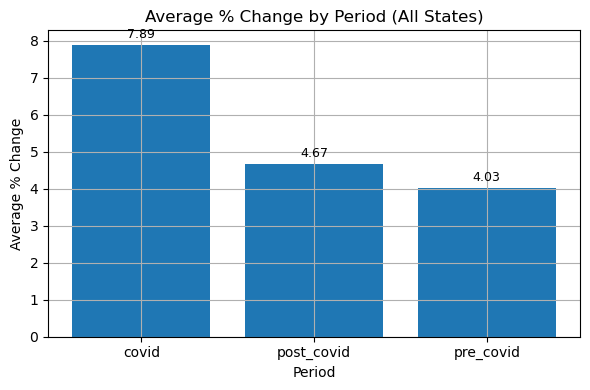

In [5]:

plot_period_bars(period_tbl, os.path.join(CFG.fig_dir, "period_comparison.png"))


## 3) State Winners & Losers (2020)

In [6]:

ranking_2020 = compute_state_rankings_2020(fb_lab)
ranking_2020.head(10)


WY    21.225000
MT    20.491667
WA    17.733333
MD    17.500000
OK    16.616667
OR    16.050000
RI    16.033333
AK    15.750000
ND    15.700000
SD    15.116667
dtype: float64

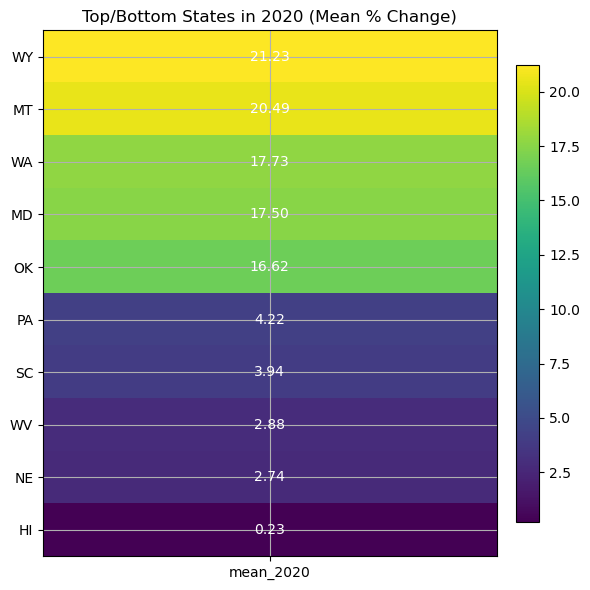

In [7]:

plot_top_bottom_heatmap(ranking_2020, os.path.join(CFG.fig_dir, "top_bottom_states_2020.png"), top_n=5)
ranking_2020.to_csv(os.path.join(CFG.out_dir, "state_rankings_2020.csv"), header=["mean_2020"])


## 4) Policy Features & Correlations (Immediate Impact Window)

In [8]:

try:
    policies = load_policy_features()
    impact = compute_impact_window(fb_lab)
    corr = spearman_corr_impact_policies(impact, policies)
    corr
except Exception as e:
    print("[WARN] Policy correlation step skipped:", e)


## 5) Patterns & Clustering

In [10]:

mat_states = month_profile_matrix(fb_lab)
mat_states.iloc[:5, :5]


month,1,2,3,4,5
AK,3.557143,5.133333,4.066667,4.500000,4.183333
AL,7.471429,8.000000,7.600000,7.400000,7.750000
AR,4.942857,2.500000,2.533333,4.333333,4.333333
AZ,5.414286,5.833333,5.083333,5.416667,5.400000
CA,4.885714,4.783333,4.283333,4.750000,4.433333


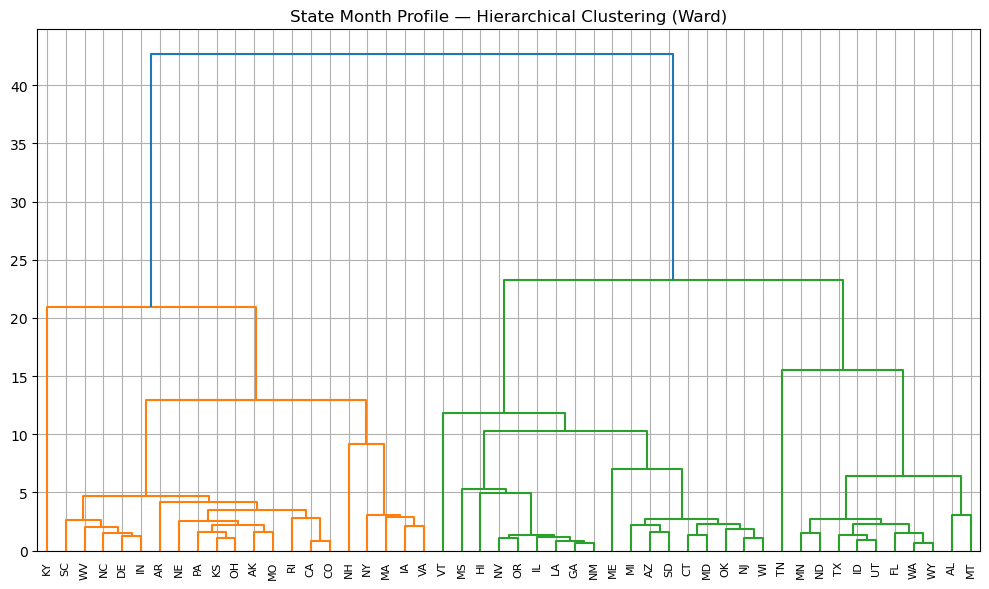

In [11]:

plot_state_dendrogram(mat_states, os.path.join(CFG.fig_dir, "state_dendrogram.png"))


In [20]:
# --- State clustering: cut tree -> labels + clustered heatmap ---
# Choose how many clusters you want:
K_STATES = 4

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns

# Linkage on the state month-profile matrix (rows=states)
Z_states = linkage(pdist(mat_states.values, metric="euclidean"), method="ward")

# Cut the tree into K_STATES clusters
state_labels = fcluster(Z_states, t=K_STATES, criterion="maxclust")

# Labeled table (state -> cluster)
state_clusters = (
    pd.DataFrame({"state": mat_states.index, "cluster": state_labels})
      .set_index("state")
      .sort_values("cluster")
)
print("Cluster sizes:\n", state_clusters.value_counts("cluster").sort_index())


Cluster sizes:
 cluster
1    20
2     1
3    18
4    11
Name: count, dtype: int64


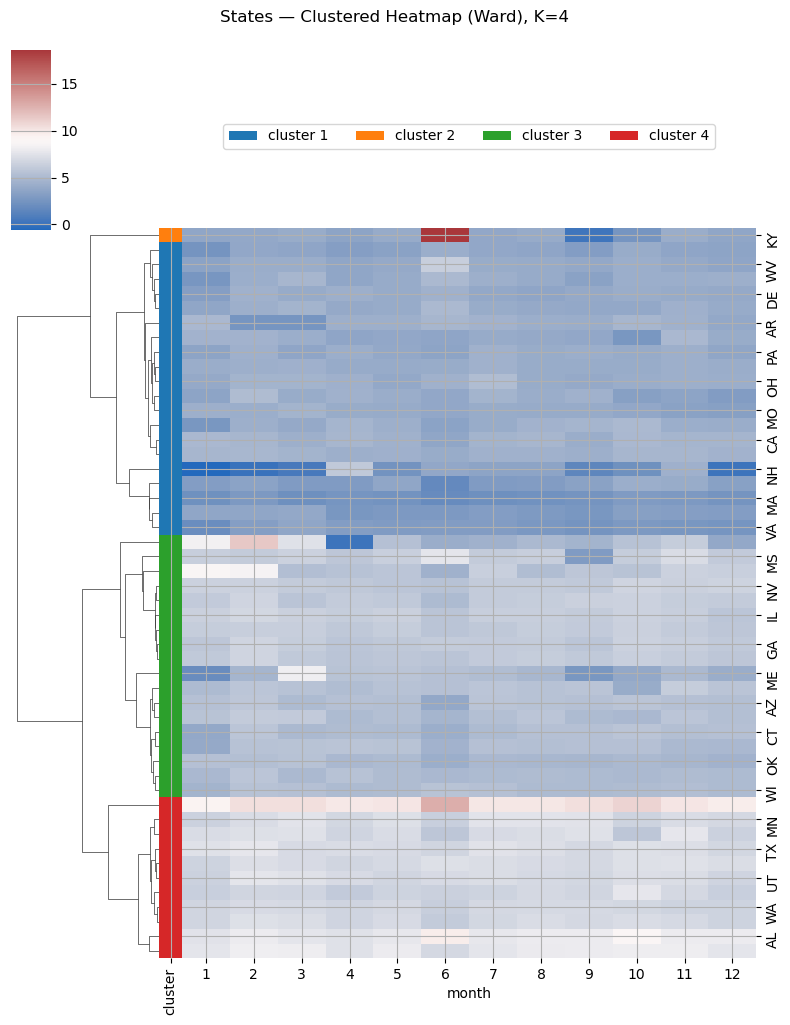

In [19]:

# Save labeled table
state_clusters.to_csv(os.path.join(CFG.out_dir, f"state_clusters_k{K_STATES}.csv"))

# Nice clustered heatmap with row colors showing cluster id
palette = sns.color_palette("tab10", K_STATES)
cluster_to_color = {c+1: palette[c] for c in range(K_STATES)}
row_colors = state_clusters["cluster"].map(cluster_to_color)

g = sns.clustermap(
    mat_states, method="ward", metric="euclidean",
    row_cluster=True, col_cluster=False,   # cluster rows (states); keep months in calendar order
    row_colors=row_colors,
    cmap="vlag", figsize=(8, 10)
)

# Legend for cluster colors
for cid, col in cluster_to_color.items():
    g.ax_col_dendrogram.bar(0, 0, color=col, label=f"cluster {cid}", linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=min(K_STATES, 5))

g.fig.suptitle(f"States — Clustered Heatmap (Ward), K={K_STATES}", y=1.02)
g.savefig(os.path.join(CFG.fig_dir, f"state_clustermap_k{K_STATES}.png"), dpi=220)
plt.show()

## 6) Forecasting (Fixed & Working) — SARIMAX with Yeo–Johnson + Seasonal Order

In [13]:

state = CFG.forecast_state
y = fb_lab[state].astype(float).copy()

# Train/test split
n = len(y); n_train = int(n*0.8)
y_train_raw = y.iloc[:n_train].copy()
y_test_raw = y.iloc[n_train:].copy()

# Neutralize outliers in TRAIN only
outlier_idx = pd.to_datetime(list(CFG.outlier_dates))
y_train_raw.loc[y_train_raw.index.isin(outlier_idx)] = np.nan

# Variance stabilization
pt = PowerTransformer(method="yeo-johnson", standardize=False)
y_train = pd.Series(pt.fit_transform(y_train_raw.values.reshape(-1,1)).ravel(), index=y_train_raw.index, name=state)
y_test = pd.Series(pt.transform(y_test_raw.values.reshape(-1,1)).ravel(), index=y_test_raw.index, name=state)

# Stationarity check (informational)
pval = adf_pvalue(y_train)
pval


0.688136134089545

In [14]:

# Tiny SARIMAX seasonal grid search (12-month seasonality)
order, seas = sarimax_grid(y_train.dropna(), s=12)
order, seas


/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored

((0, 2, 2), (1, 1, 1, 12))

In [15]:

# Fit and forecast
model = SARIMAX(y_train, order=order, seasonal_order=seas,
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

pred_test = res.get_forecast(steps=len(y_test)).predicted_mean
pred_future = res.get_forecast(steps=CFG.forecast_h).predicted_mean
future_index = pd.date_range(y.index[-1] + pd.offsets.MonthBegin(1), periods=CFG.forecast_h, freq="MS")
pred_future.index = future_index

# Inverse-transform to original scale
y_train_inv = inverse_transform(pt, y_train)
y_test_inv  = inverse_transform(pt, y_test)
pred_test_inv = inverse_transform(pt, pred_test)
pred_future_inv = inverse_transform(pt, pred_future)

# Metrics
align = y_test_inv.index.intersection(pred_test_inv.index)
y_true = y_test_inv.loc[align]; y_hat = pred_test_inv.loc[align]
mae = float(np.mean(np.abs(y_true - y_hat)))
rmse = float(np.sqrt(np.mean((y_true - y_hat)**2)))
mape = float(np.mean(np.abs((y_true - y_hat) / np.where(y_true==0, np.nan, y_true))) * 100)

metrics = {"state": state, "order": order, "seasonal_order": seas, "adf_p": pval, "mae": mae, "rmse": rmse, "mape": mape}
with open(os.path.join(CFG.out_dir, f"forecast_{state}_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
metrics


/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/diadana/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


{'state': 'WA',
 'order': (0, 2, 2),
 'seasonal_order': (1, 1, 1, 12),
 'adf_p': 0.688136134089545,
 'mae': 9.473512907622924,
 'rmse': 10.124183655910848,
 'mape': 385.5923583823078}

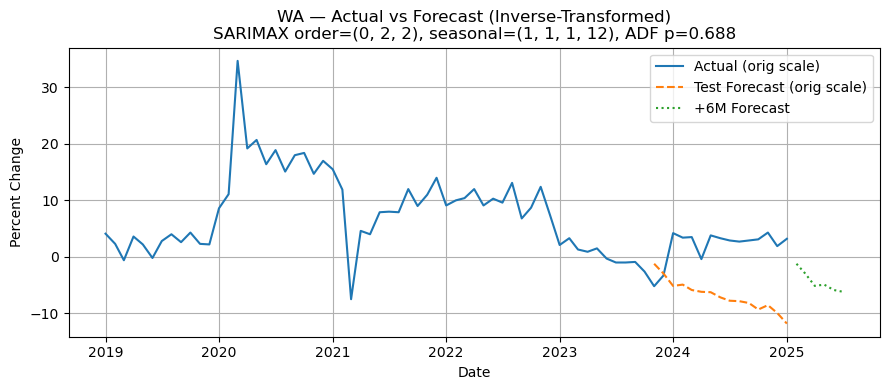

In [16]:

# Plot Actual vs Forecast (inverse-transformed)
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(y.index, y.values, label="Actual (orig scale)")
ax.plot(y_hat.index, y_hat.values, "--", label="Test Forecast (orig scale)")
ax.plot(pred_future_inv.index, pred_future_inv.values, ":", label=f"+{CFG.forecast_h}M Forecast")
ax.set_title(f"{state} — Actual vs Forecast (Inverse-Transformed)\nSARIMAX order={order}, seasonal={seas}, ADF p={pval:.3f}")
ax.set_xlabel("Date"); ax.set_ylabel("Percent Change"); ax.legend()
plt.tight_layout(); plt.savefig(os.path.join(CFG.fig_dir, f"forecast_{state}.png"), dpi=220); plt.show()

# Save forecast CSV
pd.DataFrame({"date": pred_future_inv.index, "forecast": pred_future_inv.values}).to_csv(
    os.path.join(CFG.out_dir, f"forecast_{state}.csv"), index=False
)
